In [22]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import layers
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.layers import BatchNormalization
from tqdm import tqdm
import pandas as pd
import cv2

<a id = "1"></a><br>
# Load Dataset

In [23]:
def equalization(image):
  enhanced_image = cv2.equalizeHist(image)
  return enhanced_image

#### 1. Merubah gambar ke dalam grayscale

In [24]:
def convert_to_gray(img_path):
  # img_path = cv2.imread(img_path)
  img_path = cv2.cvtColor(img_path, cv2.COLOR_RGB2GRAY)
  return img_path

#### 2. Merubah ukuran gambar menjadi 120x120

In [25]:
img_size = 120
def resize_image(img_path):
    resized_arr = cv2.resize(img_path, (img_size, img_size))
    return resized_arr

#### 3.Merubah ke dalam rgb

In [26]:
# Fungsi untuk mengubah citra ke mode RGB
def convert_to_rgb(images):
  images = cv2.imread(images)
  img = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
  return img

In [27]:
def thereshold(image):
  # Specify the threshold value and maximum value
  threshold_value = 127
  max_value = 255

  # Apply binary thresholding
  _, thresholded_image = cv2.threshold(image, threshold_value, max_value, cv2.THRESH_BINARY)
  return thresholded_image

In [28]:
labels = ['Normal', 'Cracks', 'Pothole']
nama = []
def read_images(data_dir):
    data = []
    for label in tqdm(labels, desc='Load Dataset'):
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            name = os.path.splitext(img)[0]
            rgb = convert_to_rgb(img_path)
            gray = convert_to_gray(rgb)
            ekualisasi = equalization(gray)
            theres = thereshold(ekualisasi)
            resized_arr = resize_image(theres)
            data.append([resized_arr, class_num])
            nama.append(name)
    return np.array(data) 

Dataset = read_images('train')

Load Dataset: 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10992\2098887967.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


<a id = "2"></a><br>
# Visualizing the Dataset

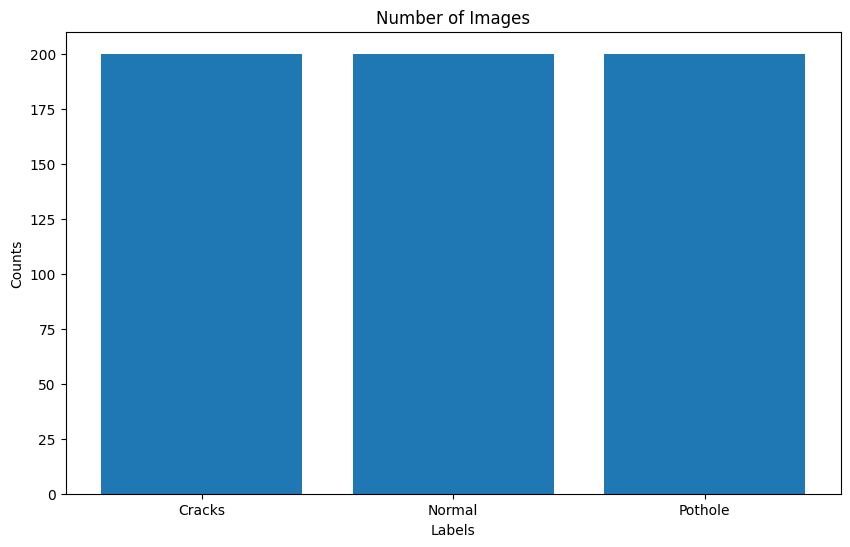

In [29]:
import matplotlib.pyplot as plt

Im = []
for i in Dataset:
    if i[1] == 0:
        Im.append("Normal")
    elif i[1] == 1:
        Im.append("Cracks")
    else:
        Im.append("Pothole")

unique_labels, label_counts = np.unique(Im, return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(unique_labels, label_counts)
plt.xlabel("Labels")
plt.ylabel("Counts")
plt.title("Number of Images")
plt.show()


<a id = "3"></a><br>
# Normalization of image data

In [30]:
def normalize(image):
    # Menghitung nilai minimum dan maksimum dari citra
    min_val = np.min(image)
    max_val = np.max(image)
    
    # Melakukan normalisasi citra menggunakan rumus min-max scaling
    normalized_image = (image - min_val) / (max_val - min_val)
    
    return normalized_image

In [31]:
hasil_normalisasi = []
labels = []
for gambar, label in Dataset:
  hasil = normalize(gambar)
  labels.append(label)
  hasil_normalisasi.append(hasil)

In [32]:
def glcm(image, distances, angles, levels):
    # Konversi gambar ke tipe data unsigned integer
    image = image.astype(np.uint8)
    
    # Hitung matriks GLCM menggunakan skimage.greycomatrix
    glcm_matrix = graycomatrix(image, distances, angles, levels=levels, symmetric=True, normed=True)
    
    # Hitung properti GLCM menggunakan skimage.greycoprops
    contrast = graycoprops(glcm_matrix, 'contrast')
    dissimilarity = graycoprops(glcm_matrix, 'dissimilarity')
    homogeneity = graycoprops(glcm_matrix, 'homogeneity')
    energy = graycoprops(glcm_matrix, 'energy')
    correlation = graycoprops(glcm_matrix, 'correlation')
    
    # Menggabungkan properti GLCM menjadi vektor fitur
    feature_vector = np.hstack([contrast.flatten(), dissimilarity.flatten(),
                                homogeneity.flatten(), energy.flatten(),
                                correlation.flatten()])
    
    return feature_vector

In [33]:
glcm_features = []

for image in tqdm((hasil_normalisasi), desc='GLCM'):
    glcm_feature = glcm(image, distances=[1], angles=[0, 45, 90, 135], levels=256)
    glcm_features.append(glcm_feature)

glcm_features = np.array(glcm_features)


GLCM: 100%|██████████| 600/600 [00:55<00:00, 10.81it/s]


In [34]:
headerPass = ['contrast0', 'dissimilarity0', 'homogenity0', 'energy0', 'correlation0', 'contrast45', 'dissimilarity45', 'homogenity45', 'energy45', 'correlation45', 'contrast90', 'dissimilarity90', 'homogenity90', 'energy90', 'correlation90', 'contrast135', 'dissimilarity135', 'homogenity135', 'energy135', 'correlation135']

# Membuat DataFrame dari glcm_features
df = pd.DataFrame(glcm_features, columns=headerPass)

df.insert(0, 'path', nama)
df['labels'] = Im

df.to_csv('glcm_features.csv', index=False)


In [35]:
df

,path,contrast0,dissimilarity0,homogenity0,energy0,correlation0,contrast45,dissimilarity45,homogenity45,energy45,...,dissimilarity90,homogenity90,energy90,correlation90,contrast135,dissimilarity135,homogenity135,energy135,correlation135,labels
0,Normal_301,0.242297,0.311207,0.290826,0.242297,0.242297,0.311207,0.290826,0.242297,0.878852,...,0.878852,0.653406,0.627948,0.635651,0.653406,0.377882,0.204734,0.253720,0.377882,Normal
1,Normal_302,0.250700,0.307535,0.289146,0.250700,0.250700,0.307535,0.289146,0.250700,0.874650,...,0.874650,0.636547,0.615016,0.621745,0.636547,0.383967,0.247709,0.291124,0.383967,Normal
2,Normal_303,0.249790,0.310995,0.299510,0.249790,0.249790,0.310995,0.299510,0.249790,0.875105,...,0.875105,0.627681,0.604344,0.608691,0.627681,0.403304,0.260400,0.286357,0.403304,Normal
3,Normal_304,0.201331,0.250265,0.226681,0.201331,0.201331,0.250265,0.226681,0.201331,0.899335,...,0.899335,0.612835,0.590118,0.600763,0.612835,0.565758,0.460786,0.511241,0.565758,Normal
4,Normal_305,0.203711,0.254361,0.237535,0.203711,0.203711,0.254361,0.237535,0.203711,0.898144,...,0.898144,0.633276,0.610735,0.618557,0.633276,0.533573,0.418394,0.455538,0.533573,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,Pothole_1980,0.115826,0.143916,0.125980,0.115826,0.115826,0.143916,0.125980,0.115826,0.942087,...,0.942087,0.643536,0.627385,0.638021,0.643536,0.760417,0.702150,0.739074,0.760417,Pothole
596,Pothole_1981,0.207913,0.226608,0.201681,0.207913,0.207913,0.226608,0.201681,0.207913,0.896043,...,0.896043,0.652219,0.642569,0.654241,0.652219,0.492802,0.449777,0.509248,0.492802,Pothole
597,Pothole_1982,0.159594,0.178518,0.167157,0.159594,0.159594,0.178518,0.167157,0.159594,0.920203,...,0.920203,0.642202,0.632005,0.638594,0.642202,0.648048,0.606718,0.630986,0.648048,Pothole
598,Pothole_1983,0.193768,0.219970,0.202591,0.193768,0.193768,0.219970,0.202591,0.193768,0.903116,...,0.903116,0.652431,0.640576,0.648905,0.652431,0.536566,0.473855,0.514605,0.536566,Pothole


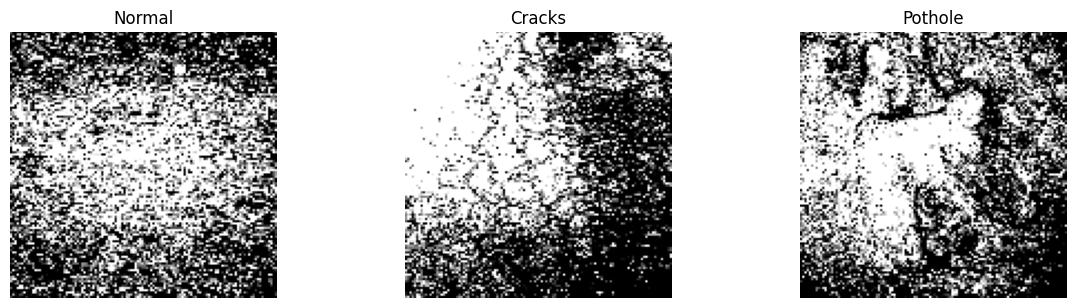

In [42]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
plt.title("Normal")
plt.imshow(hasil_normalisasi[0], cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title("Cracks")
plt.imshow(hasil_normalisasi[300], cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.title("Pothole")
plt.imshow(hasil_normalisasi[500], cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


### Membangun Model CNN

In [43]:
hasil_normalisasi = np.array(hasil_normalisasi).reshape(-1, img_size, img_size, 1)
labels = np.array(labels)

model = Sequential()
model.add(Conv2D(64,3,padding="same", activation="relu", input_shape = hasil_normalisasi.shape[1:]))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 120, 120, 64)      640       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 60, 60, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 30, 30, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 15, 128)     

### Membuat Model Training

In [44]:
# Membagi dataset menjadi data latih (80%) dan data uji (20%)
train_images, test_images, train_labels, test_labels = train_test_split(hasil_normalisasi, labels, test_size=0.2)

In [45]:
# Membuat model CNN
model = keras.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(120, 120, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(test_images, test_labels), verbose=1)


Epoch 1/10
15/15 [==============================] - 7s 276ms/step - loss: 1.1698 - accuracy: 0.4250 - val_loss: 1.0246 - val_accuracy: 0.4417
Epoch 2/10
15/15 [==============================] - 4s 247ms/step - loss: 0.8229 - accuracy: 0.6542 - val_loss: 0.7016 - val_accuracy: 0.7167
Epoch 3/10
15/15 [==============================] - 4s 250ms/step - loss: 0.6101 - accuracy: 0.7375 - val_loss: 0.5221 - val_accuracy: 0.8083
Epoch 4/10
15/15 [==============================] - 4s 245ms/step - loss: 0.5027 - accuracy: 0.8188 - val_loss: 0.4967 - val_accuracy: 0.8167
Epoch 5/10
15/15 [==============================] - 4s 252ms/step - loss: 0.3973 - accuracy: 0.8562 - val_loss: 0.3840 - val_accuracy: 0.8667
Epoch 6/10
15/15 [==============================] - 4s 252ms/step - loss: 0.2942 - accuracy: 0.8917 - val_loss: 0.3162 - val_accuracy: 0.9083
Epoch 7/10
15/15 [==============================] - 4s 251ms/step - loss: 0.2604 - accuracy: 0.8958 - val_loss: 0.3972 - val_accuracy: 0.8417
Epoch 

In [46]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### Menampilkan hasil dalam bentuk grafik

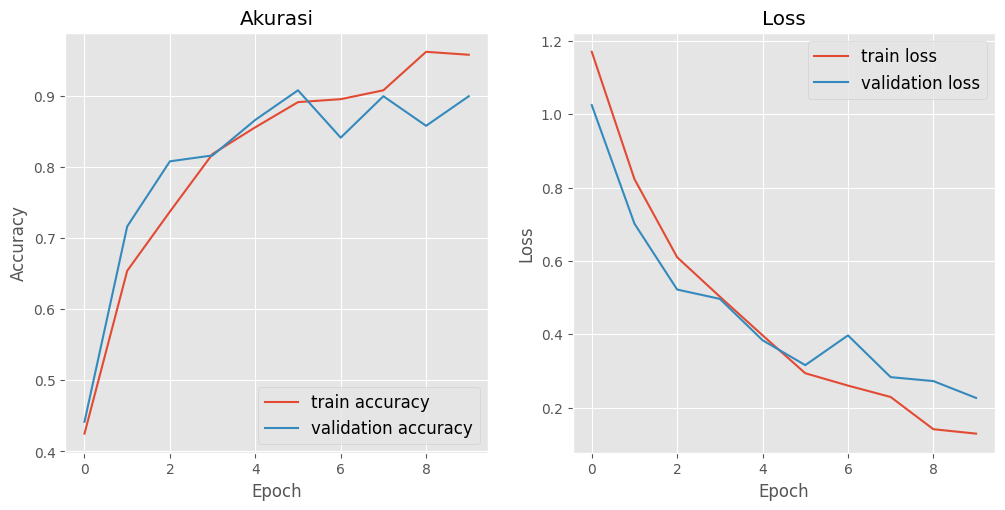

In [50]:
plt.figure(figsize=(12, 12))
plt.style.use('ggplot')
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right', prop={'size': 12})

plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train loss', 'validation loss'], loc='best', prop={'size': 12})

### Hasil Klasifikasi dalam bentuk penilaian akurasi

In [48]:
from sklearn.metrics import classification_report, accuracy_score

predictions = model.predict(hasil_normalisasi)
predicted_classes = np.argmax(predictions, axis=1)
print(classification_report(labels, predicted_classes, target_names=['Normal', 'Cracks', 'Pothole']))

accuracy = accuracy_score(labels, predicted_classes)

print("Accuracy: {:.2f}%".format(accuracy * 100))


19/19 [==============================] - 2s 68ms/step
              precision    recall  f1-score   support

      Normal       0.96      0.95      0.96       200
      Cracks       0.93      0.96      0.95       200
     Pothole       1.00      0.96      0.98       200

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600

Accuracy: 96.17%


In [49]:
from sklearn.neighbors import KNeighborsClassifier

# Reshape train_images dan test_images menjadi array 2D
train_images_flattened = train_images.reshape(train_images.shape[0], -1)
test_images_flattened = test_images.reshape(test_images.shape[0], -1)

# Inisialisasi model K-NN
knn = KNeighborsClassifier(n_neighbors=5)

# Latih model
knn.fit(train_images_flattened, train_labels)

# Prediksi menggunakan data uji
predictions = knn.predict(test_images_flattened)

# Menghitung akurasi
accuracy = accuracy_score(test_labels, predictions)

# Menampilkan hasil akurasi
print("Akurasi: {:.2f}%".format(accuracy * 100))
report = classification_report(test_labels, predictions)
print(report)


Akurasi: 65.00%
              precision    recall  f1-score   support

           0       0.61      0.77      0.68        39
           1       0.58      0.82      0.68        39
           2       1.00      0.38      0.55        42

    accuracy                           0.65       120
   macro avg       0.73      0.66      0.64       120
weighted avg       0.74      0.65      0.64       120

